# Main file for data analysis and plot generation

## 1. Generate the main dataframes necessary for each plot

The following code is used to process the raw data from the simulations. 

### Step 1: Importing all packages.

In [2]:
import os
current_working_directory = os.getcwd()

import sys
sys.path.append('Functions')

import other_functions
import data_analysis_functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import time

### Step 2: Defining the parameters for the analyses.

In [97]:
# ------------------- Parameters to adapt to your simulations -------------------

# Tag of the experiment to analyse: all folders in the /Output folder containgin this tag will be analysed
experiment_tag = "generate"

# List of metrics to compute (see dict_of_metrics for the syntax). You should only need similarity_1, similarity_2 and foraging_success
metrics_to_compute = []


# ------------------- Parameters that should be common to all simulations -------------------

# Parameters of the simulations that will be added to the final dataframes
parameters_to_save = ["time_flower_replenishment",
	"alpha",
	"beta",
	"proba_discovery_when_max_crop",
	"working_memory_span"]

# Dictionnary of all existing metrics and whether they depend on bout indices or time
dict_of_metrics = {"interactions":"bout", 
	"similarity_1":"bout", 
	"similarity_2":"bout", 
	"similarity_3":"bout", 
	"local_competition":"time", 
	"bout_durations":"bout", 
	"time_between_visits":"time",
	"entropy": "time",
	"nflowers":"bout",
	"foraging_success": "bout",
	"freq_fast": "bout",
	"intervisit_durations":"time",
	"overlap_routes": "bout",
	"sim_patch" : "bout",
    "quantity_of_nectar":"bout"}

# Put this parameter at "True" if you need to re-compute the similarity index from scratch after the simulations are finished
compute_similarity_afterwards = False

# If True, will overwrite the previously computed dataframes
overwrite_files = False

### Step 3: Initialising the information necessary to perfom the analyses.

In [98]:
# Find the /Arrays and the /Output directories
arrays_directory = current_working_directory + '\\Arrays'
output_directory = current_working_directory + '\\Output'

# Get the list of folders that contains the experiment tag
list_of_output_folders = np.array(os.listdir(output_directory))
indices_of_folders_to_analyze = np.where(other_functions.character_match(list_of_output_folders,experiment_tag))[0]
list_of_folders_to_analyze = list_of_output_folders[indices_of_folders_to_analyze]

if len(list_of_folders_to_analyze) == 0 : print('No folder to analyze found. Please check if the experiment tag is correct.')

# Get the number of parameters to save and the number of metrics to compute
number_of_parameters_to_save = len(parameters_to_save)
number_of_metrics_to_compute = len(metrics_to_compute)

# Make the /Data folder
data_directory_path = output_directory+"\\Data"
try : os.mkdir(data_directory_path)
except : print('Data directory already exists')

# Make the /Plots folder
plots_directory_path = output_directory+"\\Plots"
try : os.mkdir(plots_directory_path)
except : print('Plots directory already exists')

# Get the list of existing datframes
dataframes_already_computed = np.array(os.listdir(data_directory_path))

# Check what dataframes still need to be computed
data_analysis_functions.get_metrics_to_compute(metrics_to_compute, dataframes_already_computed, overwrite_files)

No folder to analyze found. Please check if the experiment tag is correct.
Data directory already exists


()

### Step 4: Computing the final dataframes.

In [4]:
beginning = time.time()


# Only if there are metrics to compute
if len(metrics_to_compute) != 0 : 


	# Initialize the list of outputs (now lists but later dataframes)
	outputs = [[] for i in range (len(metrics_to_compute)) ]

	# Collect the data of all files
	for output_folder_name in list_of_folders_to_analyze :

		print('Joining file for experiment '+ output_folder_name)

		# Get the path of the folder
		output_folder_path = output_directory+'\\'+ output_folder_name

		# Get the list of arrays in that folder (remove the seed and the time_constants files)
		list_of_arrays = np.array(os.listdir(output_folder_path))
		list_of_arrays = np.delete(list_of_arrays,list_of_arrays == 'time_constants.csv')
		list_of_arrays = np.delete(list_of_arrays,list_of_arrays == 'seed.csv')
		
		# Number of arrys to compute
		number_of_arrays = len(list_of_arrays)

		# Retrieve relevant time constants
		time_constants = pd.read_csv(output_folder_path+'\\time_constants.csv')
		number_of_seconds_per_timesteps = time_constants.loc[0,"number_of_seconds_per_timesteps"]
		time_flower_replenishment = time_constants.loc[0,"time_flower_replenishment"]
		number_of_timesteps_per_sim = time_constants.loc[0,"number_of_timesteps_per_sim"]

		if isinstance(time_flower_replenishment, str) : 
			time_flower_replenishment = eval(time_flower_replenishment)
			min_replenishment = min(time_flower_replenishment)	
		else :
			min_replenishment = time_flower_replenishment	

		name_of_array_info_to_save = ["type_of_array","number_of_flowers_per_patch","density_of_patches", 
								"number_of_patches", "number_of_flowers", "number_of_bees"]

		# Print progress bar
		other_functions.print_progress_bar(0, number_of_arrays*number_of_metrics_to_compute, prefix = 'Progress:', suffix = 'Complete', length = 50)

		# Loop on the arrays
		for array_number in range(number_of_arrays) : 

			# Get the folder path
			array_path = output_folder_path +'\\'+list_of_arrays[array_number]

			# Retrieve bee_info dataframe
			bee_info = pd.read_csv(array_path+'\\bee_info.csv')

			# Retrieve relevant information about the bees
			number_of_bees = len(bee_info.index)
			max_distance_travelled = bee_info.loc[0,"max_distance_travelled"]
			velocity = bee_info.loc[0,"velocity"]
			timesteps_inactive_in_nest = bee_info.loc[0,"timesteps_inactive_in_nest"]

			# Retrieve information about the array
			array_ID = bee_info["array_ID"][0]	
			array_info = pd.read_csv(arrays_directory+'\\'+array_ID+'\\array_info.csv')
			array_geometry = pd.read_csv(arrays_directory+'\\'+array_ID+'\\array_geometry.csv')
			patch_dict = {array_geometry.loc[i,"ID"] : array_geometry.loc[i,"patch"] for i in range (len(array_geometry.index))}

			foraging_range = array_info.loc[0,"foraging_range"]
			number_of_flowers = array_info.loc[0,"number_of_flowers"]
			number_of_patches = array_info.loc[0,"number_of_patches"]
			density_of_patches = array_info.loc[0,"density_of_patches"]
			type_of_array = str(number_of_flowers)+'F-'+str(number_of_patches)+'P'+'-'+str(density_of_patches)+'D'
			number_of_flowers_per_patch = number_of_flowers/number_of_patches


			array_info_to_save = [type_of_array,number_of_flowers_per_patch,density_of_patches, number_of_patches, 
						 number_of_flowers, number_of_bees]
			

			# Compute the length of a time window for the local competition and time between visits metrics
			number_of_timesteps_in_time_window = int((max_distance_travelled + foraging_range)/(velocity*number_of_seconds_per_timesteps)) + timesteps_inactive_in_nest
			number_of_timesteps_in_time_window_entropy = 5*number_of_timesteps_in_time_window

			# Get the values of the parameters to save
			list_of_parameter_to_save = []
			for param_index in range (number_of_parameters_to_save) : 
				list_of_parameter_to_save.append(bee_info.loc[0,parameters_to_save[param_index]])

			number_of_flowers = int(number_of_flowers)+1
			
			# Get the value of each metric to compute and complete the output list
			
			for i in range (len(outputs)) : 

				# Get metric name
				metric = metrics_to_compute[i]

				# Case of local competition
				if metric == "local_competition" : 
					positions_DF = pd.read_csv(array_path+'\\positions_DF.csv')
					outputs[i] += data_analysis_functions.compute_local_competition_dataframe(array_info_to_save,list_of_parameter_to_save,
						array_number,positions_DF,number_of_timesteps_in_time_window,number_of_bees,number_of_timesteps_per_sim,number_of_flowers)
				
				# Case of time between visits
				elif metric == "time_between_visits" :

					number_of_timesteps_in_time_window = 1000

					positions_DF = pd.read_csv(array_path+'\\positions_DF.csv')
					outputs[i] += data_analysis_functions.compute_time_between_visits(array_info_to_save, list_of_parameter_to_save,
						array_number,positions_DF,number_of_timesteps_in_time_window,number_of_bees,number_of_timesteps_per_sim,number_of_flowers)
				

				# Case of entropy
				elif metric == "entropy" : 
					positions_DF = pd.read_csv(array_path+'\\positions_DF.csv')
					outputs[i] += data_analysis_functions.compute_entropy_dataframe(array_info_to_save, list_of_parameter_to_save,
						array_number,positions_DF,number_of_timesteps_in_time_window_entropy,number_of_bees,number_of_timesteps_per_sim,number_of_flowers)

				# Case of nflowers
				elif metric == "nflowers" : 
					matrix_of_visit_seq = pd.read_csv(array_path+'\\matrix_of_visit_sequences.csv', header = None)
					outputs[i] += data_analysis_functions.compute_nflowers_dataframe(array_info_to_save, list_of_parameter_to_save,array_number,
						matrix_of_visit_seq)

				# Case of foraging_success
				elif metric == "foraging_success" : 
					bout_durations_DF = pd.read_csv(array_path+'\\bout_durations_DF.csv')
					quantity_of_nectar_DF = pd.read_csv(array_path+'\\quantity_of_nectar_DF.csv')
					outputs[i] += data_analysis_functions.compute_foraging_success(array_info_to_save, list_of_parameter_to_save,
						array_number,bout_durations_DF, quantity_of_nectar_DF,number_of_bees)					

				# Case of freq_fast
				elif metric == "freq_fast" : 
					matrix_flower_type = pd.read_csv(array_path+'\\matrix_flower_type.csv')
					outputs[i] += data_analysis_functions.compute_freq_fast(array_info_to_save, list_of_parameter_to_save,
						array_number,matrix_flower_type,number_of_bees, min_replenishment)					

				# Case of intervisit_durations
				elif metric == "intervisit_durations" : 
					number_of_timesteps_in_time_window = 1000
					arrival_times_DF = pd.read_csv(array_path+'\\arrival_times_DF.csv')
					outputs[i] += data_analysis_functions.compute_intervisit_duration(array_info_to_save,list_of_parameter_to_save,array_number,arrival_times_DF,
					number_of_timesteps_in_time_window,number_of_bees,number_of_timesteps_per_sim,number_of_flowers, number_of_seconds_per_timesteps)

				# Case overlap_routes
				elif metric == "overlap_routes" : 
					matrix_of_visit_seq = pd.read_csv(array_path+'\\matrix_of_visit_sequences.csv', header = None)
					outputs[i] += data_analysis_functions.compute_overlap(array_info_to_save, list_of_parameter_to_save,array_number,
						matrix_of_visit_seq)

				elif metric == "similarity_1" and compute_similarity_afterwards : 
					matrix_of_visit_seq = pd.read_csv(array_path+'\\matrix_of_visit_sequences.csv', header = None)
					outputs[i] += data_analysis_functions.compute_sim_afterwards(array_info_to_save, list_of_parameter_to_save,array_number,matrix_of_visit_seq, index=1)		

				elif metric == "similarity_2" and compute_similarity_afterwards : 
					matrix_of_visit_seq = pd.read_csv(array_path+'\\matrix_of_visit_sequences.csv', header = None)
					outputs[i] += data_analysis_functions.compute_sim_afterwards(array_info_to_save, list_of_parameter_to_save,array_number,matrix_of_visit_seq, index=2)
				
				elif metric == "similarity_3" and compute_similarity_afterwards : 
					matrix_of_visit_seq = pd.read_csv(array_path+'\\matrix_of_visit_sequences.csv', header = None)
					outputs[i] += data_analysis_functions.compute_sim_afterwards(array_info_to_save, list_of_parameter_to_save,array_number,matrix_of_visit_seq, index=3)

				elif metric=="sim_patch":
					matrix_of_visit_seq = pd.read_csv(array_path+'\\matrix_of_visit_sequences.csv', header = None)
					outputs[i] += data_analysis_functions.compute_sim_patch(array_info_to_save, list_of_parameter_to_save,
															 array_number,matrix_of_visit_seq, patch_dict)



				# General case
				else : 
					data_analysis_functions.update_output_list(array_path, metric, outputs, i, list_of_parameter_to_save, array_number, 
						array_info_to_save)

				# Print progress bar
				other_functions.print_progress_bar(array_number*number_of_metrics_to_compute+i+1, number_of_arrays*number_of_metrics_to_compute, 				
					prefix = 'Progress:', suffix = 'Complete', length = 50)

	# Save the outputs
	for i in range (len(outputs)) : 

		# Get metric name
		metric = metrics_to_compute[i]

		# Save the output as a datframe and put is back in the list
		outputs[i] = data_analysis_functions.save_final_output(outputs, i, metric, parameters_to_save, name_of_array_info_to_save, 
			dict_of_metrics, data_directory_path)



end = time.time()

print("analyses lasted for ", np.round(end-beginning, 5), " sec")


analyses lasted for  0.0  sec


## 2. Generate the plots 

The following code is used to make the plots from the article. For each figure, we will specify the dataframes that need to be computed prior to the generation of the plot.

In [3]:
# Set the style in seaborn 

sns.set(font_scale=1.5, style="ticks")

### Figure 2.C. Effect of the distance between flowers and the number of flowers

Prior to this, you should have generated the following dataframes:
- similarity_1

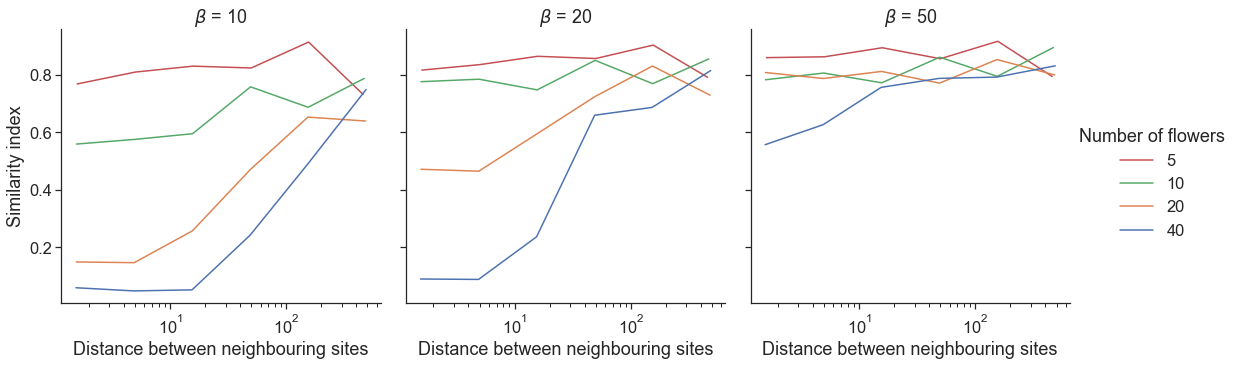

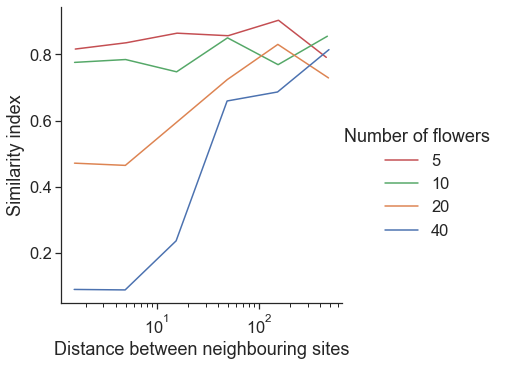

In [77]:
palette = sns.color_palette(n_colors=4)
palette.reverse()

output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')
output_similarity_1 = output_similarity_1[output_similarity_1["bout"]==10]
output_similarity_1 = output_similarity_1.reset_index()

# convert the 'density' parameter into the average distnce between nearest neighbours in environments with the same distribution of flowers

output_similarity_1["Distance between neighbouring sites"] = 0
for n in np.unique(output_similarity_1.number_of_flowers) : 
    for d in np.unique(output_similarity_1.density_of_patches) : 
        dist = float(equivalence_NN.loc[(equivalence_NN.density_of_patches == d)&(equivalence_NN.number_of_flowers == n), "average NN distance"])
        output_similarity_1.loc[(output_similarity_1.density_of_patches == d)&(output_similarity_1.number_of_flowers == n),"Distance between neighbouring sites"] = round(dist,4)


output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_1["Density$^{-1}$"] = 1/output_similarity_1["density_of_patches"]
output_similarity_1["Number of flowers"] = output_similarity_1["number_of_flowers"]
output_similarity_1["$\\beta$"] = output_similarity_1["beta"]


sns.relplot(kind="line", data=output_similarity_1, x="Distance between neighbouring sites", 
            y="Similarity index", hue="Number of flowers",col="$\\beta$", palette=palette, ci=None)
plt.xscale('log')
plt.show()


sns.relplot(kind="line", data=output_similarity_1[output_similarity_1.beta == 20], 
            x="Distance between neighbouring sites", y="Similarity index", hue="Number of flowers", palette=palette, ci=None)
plt.xscale('log')
plt.show()

### Figure 3.A and 3.B. Effect of the working memory span

Prior to this, you should have generated the following dataframes:
- similarity_1
- similarity_2
- foraging success

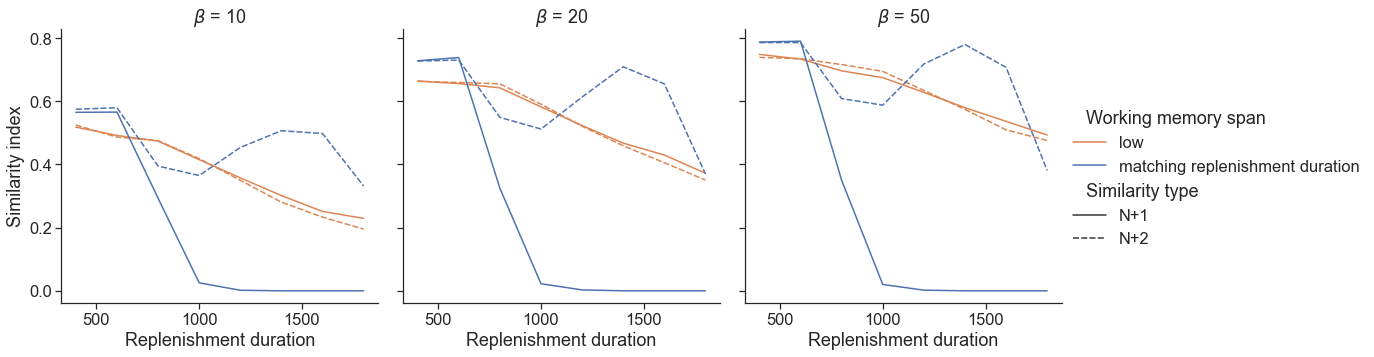

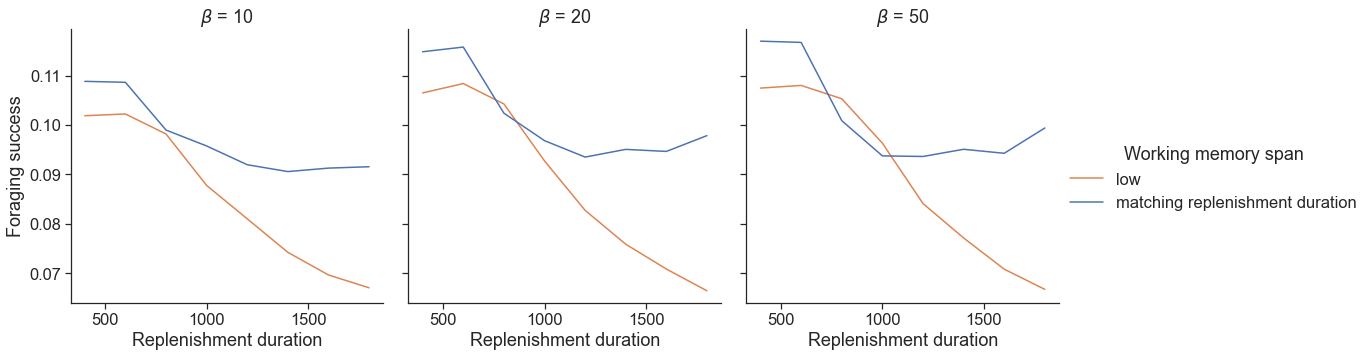

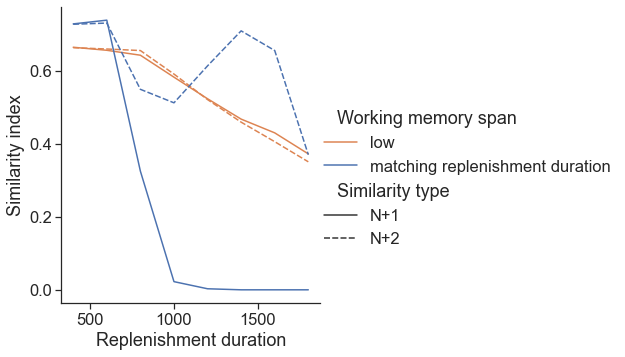

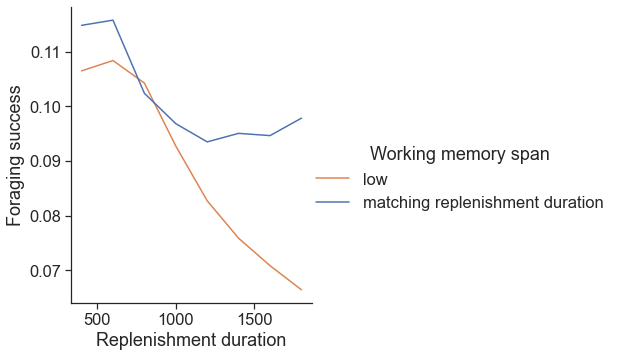

In [9]:
palette = sns.color_palette(n_colors=2)
palette.reverse()

output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')
output_similarity_1 = output_similarity_1[output_similarity_1["bout"]==15]

output_similarity_2 = pd.read_csv(data_directory_path+'\\similarity_2.csv')
output_similarity_2 = output_similarity_2[output_similarity_2["bout"]==15]


output_similarity_1["Similarity type"] = "N+1"
output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_2["Similarity type"] = "N+2"
output_similarity_2["Similarity index"] = output_similarity_2["similarity_2"] 

output = output_similarity_1.merge(output_similarity_2, how='outer')
output["Working memory span"] = output["working_memory_span"]
output["Replenishment duration"] = output["time_flower_replenishment"]
output.loc[(output["working_memory_span"]!=30),"Working memory span"] = "matching replenishment duration"
output.loc[(output["working_memory_span"]==30),"Working memory span"] = "low"
output["$\\beta$"] = output["beta"].astype("int32")

sns.relplot(kind="line", data=output, x="Replenishment duration", y="Similarity index", 
            hue="Working memory span", style="Similarity type", col="$\\beta$", palette=palette, ci=None)

plt.show()

output_foraging_succ = pd.read_csv(data_directory_path+'\\foraging_success.csv')
output_foraging_succ = output_foraging_succ[output_foraging_succ["bout"]==15]

output_foraging_succ["Working memory span"] = output_foraging_succ["working_memory_span"]
output_foraging_succ["Replenishment duration"] = output_foraging_succ["time_flower_replenishment"]
output_foraging_succ["Foraging success"] = output_foraging_succ["foraging_success"]
output_foraging_succ.loc[(output_foraging_succ["working_memory_span"]!=30),"Working memory span"] = "matching replenishment duration"
output_foraging_succ.loc[(output_foraging_succ["working_memory_span"]==30),"Working memory span"] = "low"
output_foraging_succ["$\\beta$"] = output_foraging_succ["beta"].astype("int32")

sns.relplot(kind="line", data=output_foraging_succ, x="Replenishment duration", y="Foraging success", 
            hue="Working memory span", col="$\\beta$",  palette=palette, ci=None)

plt.show()


sns.relplot(kind="line", data=output[output.beta==20], x="Replenishment duration", y="Similarity index", 
            hue="Working memory span", style="Similarity type", palette=palette, ci=None)
plt.show()

sns.relplot(kind="line", data=output_foraging_succ[output_foraging_succ.beta==20], x="Replenishment duration", y="Foraging success", 
            hue="Working memory span", palette=palette, ci=None)
plt.show()

### Figure 4.A and 4.B. Effect of the number of nestmates

Prior to this, you should have generated the following dataframes:
- similarity_1
- foraging success

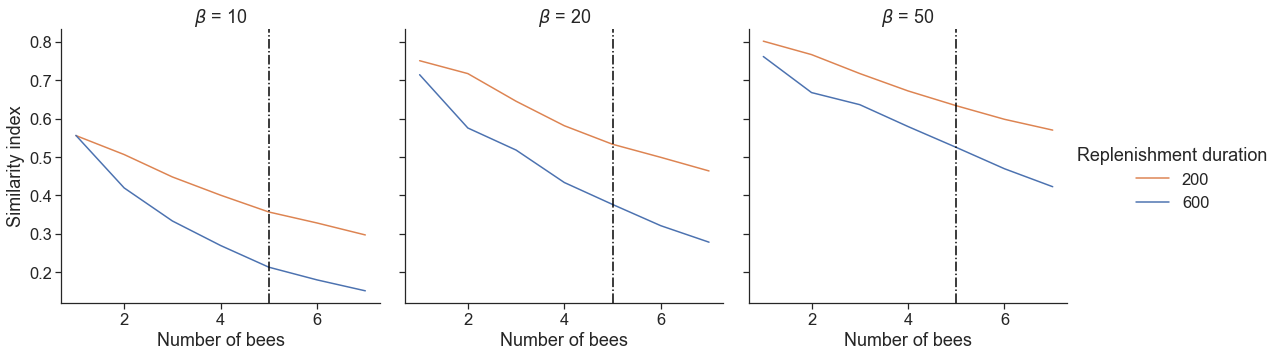

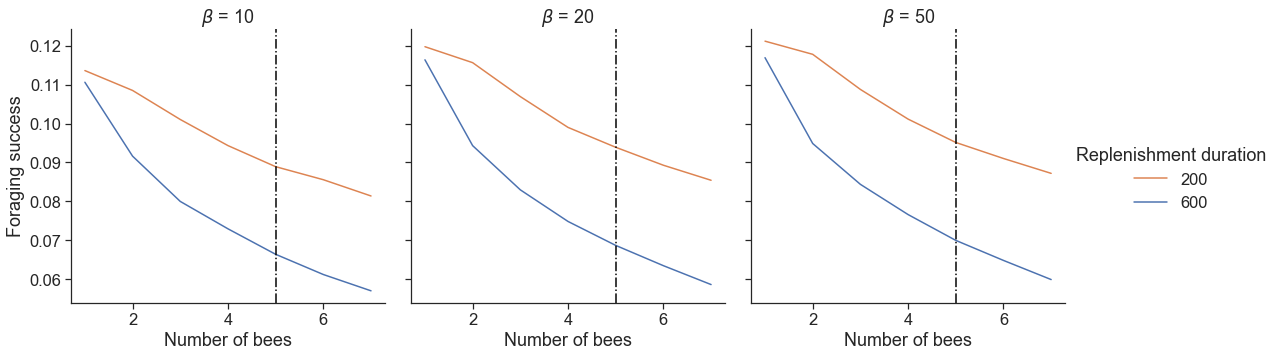

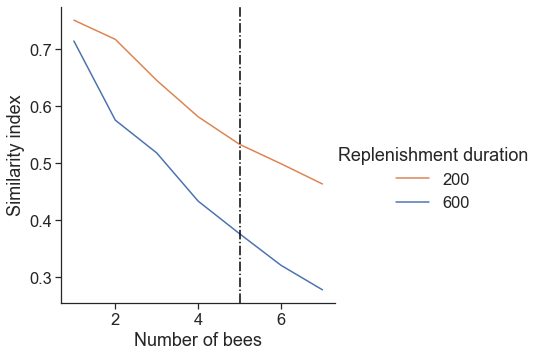

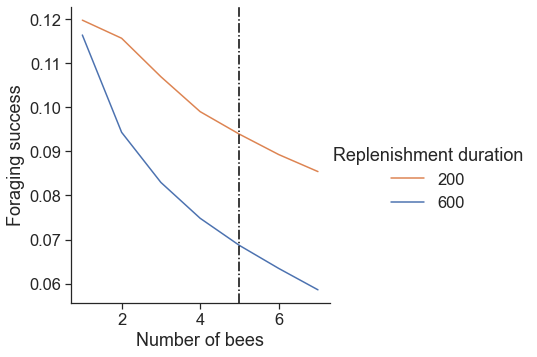

In [10]:
palette = sns.color_palette(n_colors=2)
palette.reverse()

output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')
output_similarity_1 = output_similarity_1[(output_similarity_1["bout"]==15)]

output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_1["Number of bees"] = output_similarity_1["number_of_bees"] 
output_similarity_1["$\\beta$"] = output_similarity_1["beta"]
output_similarity_1["Replenishment duration"] = output_similarity_1["time_flower_replenishment"] 

rel = sns.relplot(kind="line", data=output_similarity_1, x="Number of bees", y="Similarity index", col='$\\beta$', hue="Replenishment duration", palette=palette, ci=None)
axes = rel.axes
for col in range (3) : 
    axes[0,col].axvline(5,  linestyle='-.', color='black')
plt.show()


output_success = pd.read_csv(data_directory_path+'\\foraging_success.csv')
output_success = output_success[(output_success["bout"]==15)]

output_success["Foraging success"] = output_success["foraging_success"] 
output_success["Number of bees"] = output_success["number_of_bees"] 
output_success["$\\beta$"] = output_success["beta"]
output_success["Replenishment duration"] = output_success["time_flower_replenishment"] 

rel = sns.relplot(kind="line", data=output_success, x="Number of bees", y="Foraging success", col='$\\beta$',  hue="Replenishment duration", palette=palette, ci=None)
axes = rel.axes
for col in range (3) : 
    axes[0,col].axvline(5,  linestyle='-.', color='black')
plt.show()


sns.relplot(kind="line", data=output_similarity_1[output_similarity_1.beta==20], 
                  x="Number of bees", y="Similarity index",
                  hue="Replenishment duration", palette=palette, ci=None)
plt.axvline(5,  linestyle='-.', color='black')
plt.show()

sns.relplot(kind="line", data=output_success[output_success.beta==20], 
                  x="Number of bees", y="Foraging success", 
                  hue="Replenishment duration", palette=palette, ci=None)
plt.axvline(5,  linestyle='-.', color='black')
plt.show()

### Figure S6 and S7. Effect of the cognitive strategy.

Prior to this, you should have generated the following dataframes:
- similarity_1
- foraging success

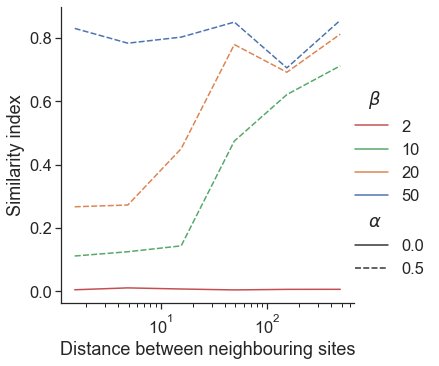

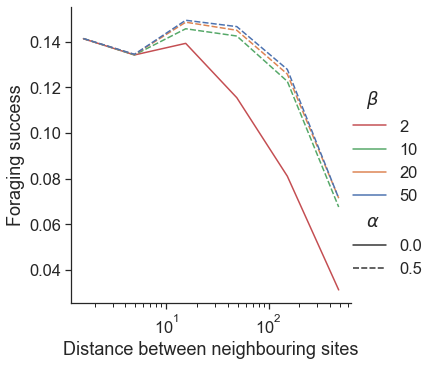

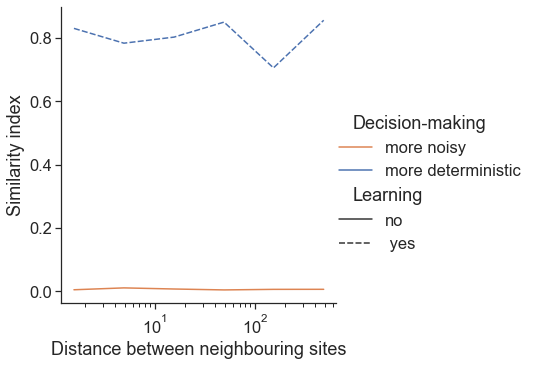

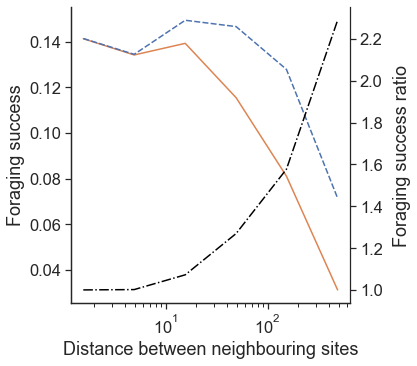

In [70]:
palette = sns.color_palette(n_colors=4)
palette.reverse()


output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')
output_similarity_1 = output_similarity_1[output_similarity_1["bout"]==10].reset_index()

equivalence_NN = pd.read_csv(arrays_directory+'\\equivalence_NN_1patch.csv')
output_similarity_1["Distance between neighbouring sites"] = 0
for n in np.unique(output_similarity_1.number_of_flowers) : 
    for d in np.unique(output_similarity_1.density_of_patches) : 
        dist = float(equivalence_NN.loc[(equivalence_NN.density_of_patches == d)&(equivalence_NN.number_of_flowers == n), "average NN distance"])
        output_similarity_1.loc[(output_similarity_1.density_of_patches == d)&(output_similarity_1.number_of_flowers == n),"Distance between neighbouring sites"] = round(dist,4)



output_similarity_1 = output_similarity_1[((output_similarity_1.alpha==0) & (output_similarity_1.beta==2)) | 
                                          (output_similarity_1.alpha==0.5)& (output_similarity_1.beta>2)]

output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_1["Density$^{-1}$"] = 1/output_similarity_1["density_of_patches"]
output_similarity_1["$\\beta$"] = output_similarity_1["beta"] 
output_similarity_1["$\\alpha$"] = output_similarity_1["alpha"] 

sns.relplot(kind="line", data=output_similarity_1, x="Distance between neighbouring sites", y="Similarity index", 
            hue="$\\beta$", style = "$\\alpha$",palette=palette, ci=None)
plt.xscale('log')
plt.show()


output_foraging_success = pd.read_csv(data_directory_path+'\\foraging_success.csv')
output_foraging_success = output_foraging_success[output_foraging_success["bout"]==10].reset_index()

output_foraging_success["Distance between neighbouring sites"] = 0
for n in np.unique(output_foraging_success.number_of_flowers) : 
    for d in np.unique(output_foraging_success.density_of_patches) : 
        dist = float(equivalence_NN.loc[(equivalence_NN.density_of_patches == d)&(equivalence_NN.number_of_flowers == n), "average NN distance"])
        output_foraging_success.loc[(output_foraging_success.density_of_patches == d)&(output_foraging_success.number_of_flowers == n),"Distance between neighbouring sites"] = round(dist,4)



output_foraging_success = output_foraging_success[((output_foraging_success.alpha==0) & (output_foraging_success.beta==2)) | 
                                          (output_foraging_success.alpha==0.5)& (output_foraging_success.beta>2)]

output_foraging_success["Foraging success"] = output_foraging_success["foraging_success"] 
output_foraging_success["Density$^{-1}$"] = 1/output_foraging_success["density_of_patches"]
output_foraging_success["$\\beta$"] = output_foraging_success["beta"] 
output_foraging_success["$\\alpha$"] = output_foraging_success["alpha"] 

sns.relplot(kind="line", data=output_foraging_success, x="Distance between neighbouring sites", y="Foraging success", 
            hue="$\\beta$", style = "$\\alpha$", palette=palette, ci=None)
plt.xscale('log')
plt.show()








palette = sns.color_palette(n_colors=2)
palette.reverse()

output_similarity_1["Decision-making"] = ""
output_similarity_1.loc[(output_similarity_1["beta"]==2),"Decision-making"] = "more noisy"
output_similarity_1.loc[(output_similarity_1["beta"]==50),"Decision-making"] = "more deterministic"
output_similarity_1 = output_similarity_1[output_similarity_1["Decision-making"] != ""]

output_similarity_1["Learning"] = ""
output_similarity_1.loc[(output_similarity_1["alpha"]==0),"Learning"] = "no"
output_similarity_1.loc[(output_similarity_1["alpha"]==0.5),"Learning"] = " yes"
output_similarity_1 = output_similarity_1[output_similarity_1["Learning"] != ""]


sns.relplot(kind="line", data=output_similarity_1, x="Distance between neighbouring sites", y="Similarity index", 
            hue="Decision-making", style="Learning", palette=palette, ci=None)
plt.xscale('log')
plt.show()



output_foraging_success["Decision-making"] = ""
output_foraging_success.loc[(output_foraging_success["beta"]==2),"Decision-making"] = "more noisy"
output_foraging_success.loc[(output_foraging_success["beta"]==50),"Decision-making"] = "more deterministic"
output_foraging_success = output_foraging_success[output_foraging_success["Decision-making"] != ""]

output_foraging_success["Learning"] = ""
output_foraging_success.loc[(output_foraging_success["alpha"]==0),"Learning"] = "no"
output_foraging_success.loc[(output_foraging_success["alpha"]==0.5),"Learning"] = "yes"
output_foraging_success = output_foraging_success[output_foraging_success["Learning"] != ""]

rel = sns.relplot(kind="line", data=output_foraging_success, x="Distance between neighbouring sites", y="Foraging success", 
            hue="Decision-making", style="Learning", palette=palette, ci=None, legend=False)

ax = rel.axes[0,0]
ax1 = ax.twinx()

data = output_foraging_success[["Distance between neighbouring sites", "Learning","Foraging success"]].groupby(["Distance between neighbouring sites", "Learning"]).mean()["Foraging success"].reset_index()
data1 = data[data["Learning"]=="no"].reset_index()
data2 = data[data["Learning"]=="yes"].reset_index()
data1["Foraging success ratio"] = data2["Foraging success"]/data1["Foraging success"]

sns.lineplot(ax=ax1, data=data1, x="Distance between neighbouring sites", y="Foraging success ratio",  color='black', linestyle='-.', ci=None)
ax1.set_xscale('log')
ax1.set_ylabel("Foraging success ratio", labelpad=10)
sns.despine(ax=ax1, top=True, right=False)


plt.show()


## 3. Supplementary plots (facetgrids) to determine at which bout the metrics reach a stable state.

The following code is used to make the plots that show the temporal evolution of metrics. They were used to determine at which bout the metrics reached a stable state that was used in the main plots of the article.

In [ ]:
# Set the style in seaborn 

sns.set(font_scale=1., style="ticks")

### Figure S8. Effect of the distance between flowers and the number of flowers

Prior to this, you should have generated the following dataframes:
- similarity_1

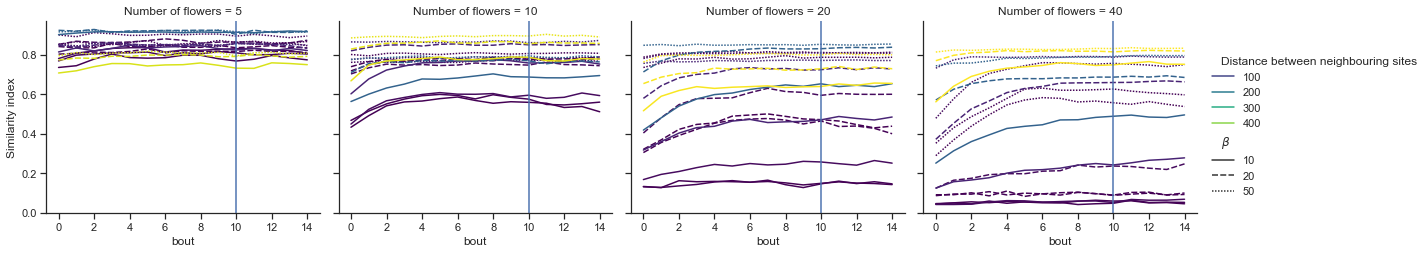

In [90]:
output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')
output_similarity_1 = output_similarity_1.reset_index()

equivalence_NN = pd.read_csv(arrays_directory+'\\equivalence_NN_1patch.csv')
output_similarity_1["Distance between neighbouring sites"] = 0
for n in np.unique(output_similarity_1.number_of_flowers) : 
    for d in np.unique(output_similarity_1.density_of_patches) : 
        dist = float(equivalence_NN.loc[(equivalence_NN.density_of_patches == d)&(equivalence_NN.number_of_flowers == n), "average NN distance"])
        output_similarity_1.loc[(output_similarity_1.density_of_patches == d)&(output_similarity_1.number_of_flowers == n),"Distance between neighbouring sites"] = round(dist,4)


output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_1["Density$^{-1}$"] = 1/output_similarity_1["density_of_patches"]
output_similarity_1["Number of flowers"] = output_similarity_1["number_of_flowers"]
output_similarity_1["$\\beta$"] = output_similarity_1["beta"]

duration_sim = output_similarity_1.groupby(["Distance between neighbouring sites", "Number of flowers", "$\\beta$", "array_number", "sim"])["bout"].max().reset_index()
max_bout = duration_sim.groupby(["Distance between neighbouring sites", "Number of flowers","$\\beta$"])["bout"].min().reset_index()
output_similarity_1 = output_similarity_1[output_similarity_1["bout"]<=max_bout["bout"].min()+1]

rel = sns.relplot(kind="line", data=output_similarity_1, x="bout", y="Similarity index", hue="Distance between neighbouring sites", 
            col="Number of flowers",style="$\\beta$", palette="viridis", ci=None, height = 3.5, aspect = 1.2)

for ax in rel.axes.flat:
    ax.axvline(x=10)
plt.show()

### Figure S8, S9 and S10. Effect of the working memory span

Prior to this, you should have generated the following dataframes:
- similarity_1
- similarity_2
- foraging success

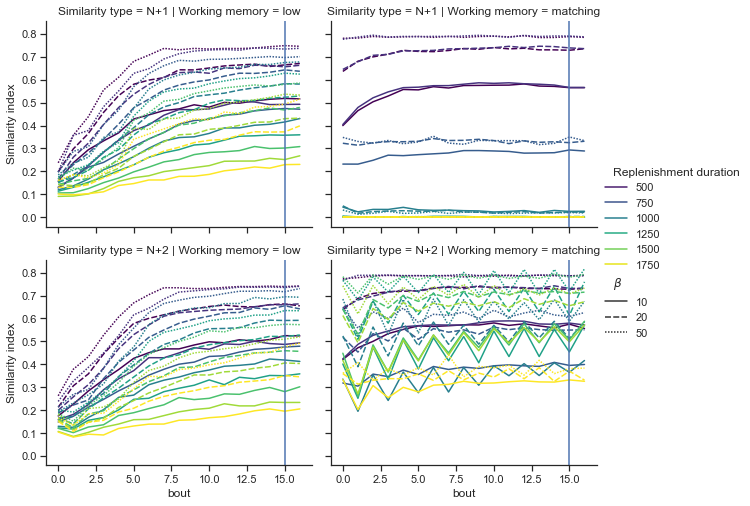

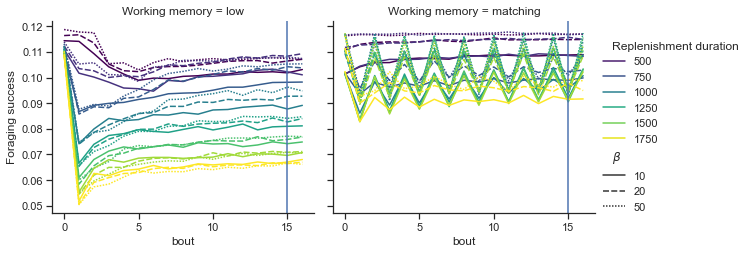

In [86]:
output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')
output_similarity_2 = pd.read_csv(data_directory_path+'\\similarity_2.csv')


output_similarity_1["Similarity type"] = "N+1"
output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_2["Similarity type"] = "N+2"
output_similarity_2["Similarity index"] = output_similarity_2["similarity_2"] 

output = output_similarity_1.merge(output_similarity_2, how='outer')
output["Working memory"] = output["working_memory_span"]
output["Replenishment duration"] = output["time_flower_replenishment"]
output.loc[(output["working_memory_span"]!=30),"Working memory"] = "matching"
output.loc[(output["working_memory_span"]==30),"Working memory"] = "low"
output["$\\beta$"] = output["beta"].astype("int32")


duration_sim = output.groupby(["Similarity type", "Working memory", "Replenishment duration","$\\beta$", "array_number", "sim"])["bout"].max().reset_index()
max_bout = duration_sim.groupby(["Similarity type","Replenishment duration","$\\beta$", "Working memory"])["bout"].min().reset_index()
output = output[output["bout"]<=max_bout["bout"].min()+1]

rel = sns.relplot(kind="line", data=output, x='bout', y="Similarity index", col="Working memory",
            hue="Replenishment duration", row="Similarity type", style="$\\beta$", palette="viridis", ci=None, height = 3.5, aspect = 1.2)

for ax in rel.axes.flat:
    ax.axvline(x=15)

plt.show()


output_foraging_succ = pd.read_csv(data_directory_path+'\\foraging_success.csv')

output_foraging_succ["Working memory"] = output_foraging_succ["working_memory_span"]
output_foraging_succ["Replenishment duration"] = output_foraging_succ["time_flower_replenishment"]
output_foraging_succ["Foraging success"] = output_foraging_succ["foraging_success"]
output_foraging_succ.loc[(output_foraging_succ["working_memory_span"]!=30),"Working memory"] = "matching"
output_foraging_succ.loc[(output_foraging_succ["working_memory_span"]==30),"Working memory"] = "low"
output_foraging_succ["$\\beta$"] = output_foraging_succ["beta"].astype("int32")
output_foraging_succ = output_foraging_succ[output_foraging_succ["bout"]<=max_bout["bout"].min()+1]


rel = sns.relplot(kind="line", data=output_foraging_succ, x="bout", y="Foraging success", 
            col="Working memory", hue="Replenishment duration", style="$\\beta$", palette="viridis", ci=None, height = 3.5, aspect = 1.2)
for ax in rel.axes.flat:
    ax.axvline(x=15)
plt.show()

### Figure S11 and S12. Effect of the number of nestmates

Prior to this, you should have generated the following dataframes:
- similarity_1
- foraging success

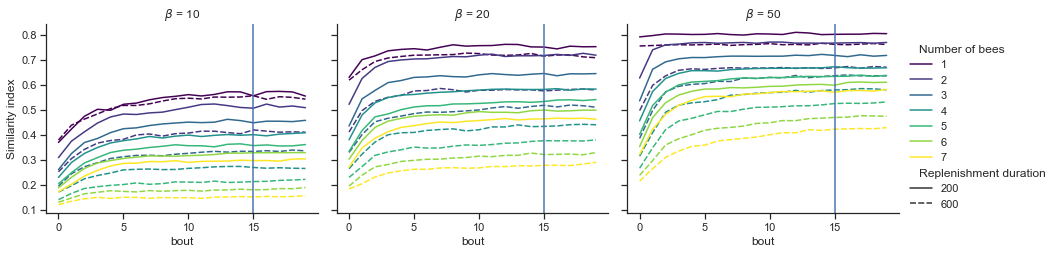

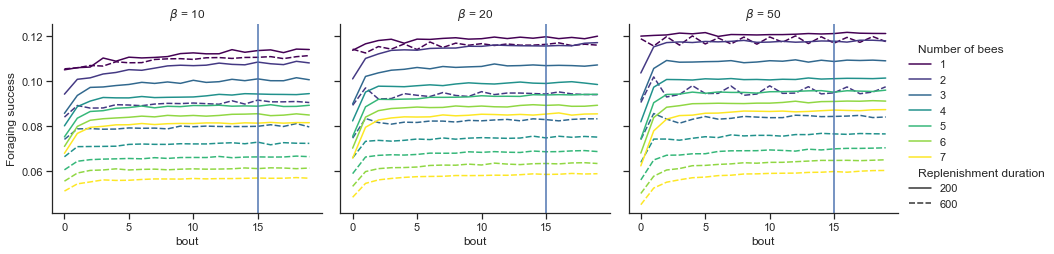

In [95]:
output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')

output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_1["Number of bees"] = output_similarity_1["number_of_bees"] 
output_similarity_1["$\\beta$"] = output_similarity_1["beta"]
output_similarity_1["Replenishment duration"] = output_similarity_1["time_flower_replenishment"] 

duration_sim = output_similarity_1.groupby(["Replenishment duration", "Number of bees", "$\\beta$", "array_number", "sim"])["bout"].max().reset_index()
max_bout = duration_sim.groupby(["Replenishment duration", "Number of bees", "$\\beta$"])["bout"].min().reset_index()
output_similarity_1 = output_similarity_1[output_similarity_1["bout"]<=max_bout["bout"].min()+1]

rel = sns.relplot(kind="line", data=output_similarity_1, x='bout', hue="Number of bees", y="Similarity index", col='$\\beta$', style="Replenishment duration", palette="viridis", ci=None, height = 3.5, aspect = 1.2)
for ax in rel.axes.flat:
    ax.axvline(x=15)
plt.show()


output_success = pd.read_csv(data_directory_path+'\\foraging_success.csv')

output_success["Foraging success"] = output_success["foraging_success"] 
output_success["Number of bees"] = output_success["number_of_bees"] 
output_success["$\\beta$"] = output_success["beta"]
output_success["Replenishment duration"] = output_success["time_flower_replenishment"] 
output_success = output_success[output_success["bout"]<=max_bout["bout"].min()+1]

rel = sns.relplot(kind="line", data=output_success, x='bout', hue="Number of bees", y="Foraging success", col='$\\beta$', style="Replenishment duration", palette="viridis", ci=None, height = 3.5, aspect = 1.2)
for ax in rel.axes.flat:
    ax.axvline(x=15)
plt.show()


### Figure S13. Effect of the cognitive strategy.

Prior to this, you should have generated the following dataframes:
- similarity_1
- foraging success

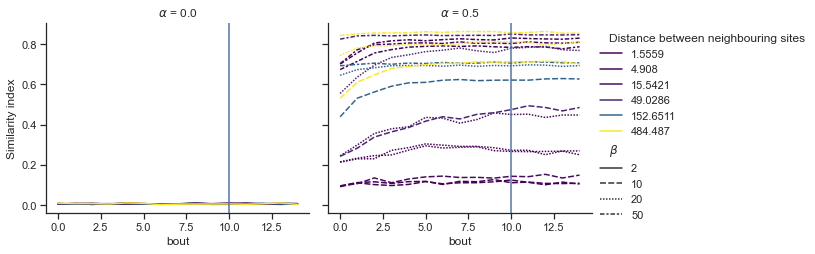

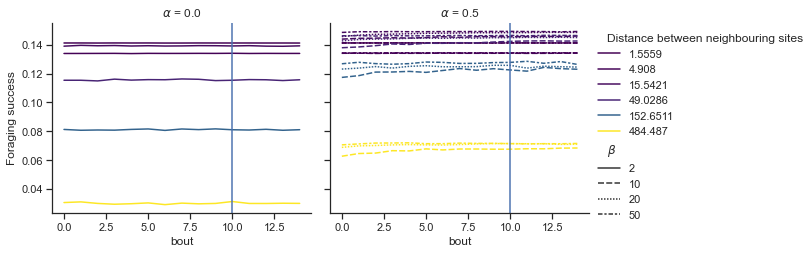

In [106]:
output_similarity_1 = pd.read_csv(data_directory_path+'\\similarity_1.csv')

equivalence_NN = pd.read_csv(arrays_directory+'\\equivalence_NN_1patch.csv')
output_similarity_1["Distance between neighbouring sites"] = 0
for n in np.unique(output_similarity_1.number_of_flowers) : 
    for d in np.unique(output_similarity_1.density_of_patches) : 
        dist = float(equivalence_NN.loc[(equivalence_NN.density_of_patches == d)&(equivalence_NN.number_of_flowers == n), "average NN distance"])
        output_similarity_1.loc[(output_similarity_1.density_of_patches == d)&(output_similarity_1.number_of_flowers == n),"Distance between neighbouring sites"] = round(dist,4)



output_similarity_1 = output_similarity_1[((output_similarity_1.alpha==0) & (output_similarity_1.beta==2)) | 
                                          (output_similarity_1.alpha==0.5)& (output_similarity_1.beta>2)]

output_similarity_1["Similarity index"] = output_similarity_1["similarity_1"] 
output_similarity_1["Density$^{-1}$"] = 1/output_similarity_1["density_of_patches"]
output_similarity_1["$\\beta$"] = output_similarity_1["beta"] 
output_similarity_1["$\\alpha$"] = output_similarity_1["alpha"] 

duration_sim = output_similarity_1.groupby(["Distance between neighbouring sites", "$\\beta$", "$\\alpha$", "array_number", "sim"])["bout"].max().reset_index()
max_bout = duration_sim.groupby(["Distance between neighbouring sites", "$\\beta$", "$\\alpha$"])["bout"].min().reset_index()
output_similarity_1 = output_similarity_1[output_similarity_1["bout"]<=max_bout["bout"].min()+1]


rel = sns.relplot(kind="line", data=output_similarity_1, x='bout',hue="Distance between neighbouring sites", y="Similarity index", 
            style="$\\beta$", col = "$\\alpha$",palette="viridis", ci=None, height = 3.5, aspect = 1.2)
for ax in rel.axes.flat:
    ax.axvline(x=10)
plt.show()


output_foraging_success = pd.read_csv(data_directory_path+'\\foraging_success.csv')

output_foraging_success["Distance between neighbouring sites"] = 0
for n in np.unique(output_foraging_success.number_of_flowers) : 
    for d in np.unique(output_foraging_success.density_of_patches) : 
        dist = float(equivalence_NN.loc[(equivalence_NN.density_of_patches == d)&(equivalence_NN.number_of_flowers == n), "average NN distance"])
        output_foraging_success.loc[(output_foraging_success.density_of_patches == d)&(output_foraging_success.number_of_flowers == n),"Distance between neighbouring sites"] = round(dist,4)



output_foraging_success = output_foraging_success[((output_foraging_success.alpha==0) & (output_foraging_success.beta==2)) | 
                                          (output_foraging_success.alpha==0.5)& (output_foraging_success.beta>2)]

output_foraging_success["Foraging success"] = output_foraging_success["foraging_success"] 
output_foraging_success["Density$^{-1}$"] = 1/output_foraging_success["density_of_patches"]
output_foraging_success["$\\beta$"] = output_foraging_success["beta"] 
output_foraging_success["$\\alpha$"] = output_foraging_success["alpha"] 
output_foraging_success = output_foraging_success[output_foraging_success["bout"]<=max_bout["bout"].min()+1]


rel = sns.relplot(kind="line", data=output_foraging_success,x="bout", hue="Distance between neighbouring sites", y="Foraging success", 
            style="$\\beta$", col = "$\\alpha$", palette="viridis", ci=None, height = 3.5, aspect = 1.2)

for ax in rel.axes.flat:
    ax.axvline(x=10)
plt.show()
